<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/breakhis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Breast Cancer Histopathological Database - UFPR](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/)

In [312]:
from google.colab import drive
import os, sys, shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import tensorflow as tf
import keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

sns.set_theme()

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyfastcopy
import pyfastcopy

In [2]:
print("Quantidade de Amostras Benignas:",
      len(os.listdir('/content/drive/MyDrive/data_400X/SOB/400X/benign')))

print("Quantidade de Amostras Malignas:",
      len(os.listdir('/content/drive/MyDrive/data_400X/SOB/400X/malignant')))

Quantidade de Amostras Benignas: 588
Quantidade de Amostras Malignas: 1232


In [3]:
caminho_base = "/content/drive/MyDrive/data_400X/SOB/400X"

In [7]:
lista_imgs_b = glob(r"/content/drive/MyDrive/data_400X/SOB/400X/benign/*.png")
lista_imgs_m = glob(r"/content/drive/MyDrive/data_400X/SOB/400X/malignant/*.png")

lista_imgs_b = shuffle(lista_imgs_b, random_state = 42)
lista_imgs_m = shuffle(lista_imgs_m, random_state=42)

In [25]:
lista_imgs_b[:2]

['/content/drive/MyDrive/data_400X/SOB/400X/benign/SOB_B_TA-14-16184CD-400-022.png',
 '/content/drive/MyDrive/data_400X/SOB/400X/benign/SOB_B_F-14-23060CD-400-015.png']

In [11]:
lista_imgs_m[:2]

['/content/drive/MyDrive/data_400X/SOB/400X/malignant/SOB_M_DC-14-9461-400-025.png',
 '/content/drive/MyDrive/data_400X/SOB/400X/malignant/SOB_M_DC-14-12312-400-024.png']

## Copiando Imagens para o Google Colab

In [26]:
# Criando uma nova pasta/diretório
dir_base = 'dir_base'
os.mkdir(dir_base)

# Dentro da pasta "dir_base", haverá a seguinte estrutura:

# dir_treino
    # a_benigno
    # b_maligno

# dir_teste
    # a_benigno
    # b_maligno


# Criando a pasta "dir_treino"
dir_treino = os.path.join(dir_base, 'dir_treino')
os.mkdir(dir_treino)

# Criando a pasta "dir_teste"
dir_teste = os.path.join(dir_base, 'dir_teste')
os.mkdir(dir_teste)


# Criando as pastas que ficarão dentro das pastas "dir_treino" e "dir_teste"
# Dentro dessas pastas estarão as imagens correspondentes a cada um dos labels

# Crindo pastas dentro de "dir_treino"
benigno = os.path.join(dir_treino, 'a_benigno')
os.mkdir(benigno)
maligno = os.path.join(dir_treino, 'b_maligno')
os.mkdir(maligno)

# Criando pastas dentro de "dir_teste"
benigno = os.path.join(dir_teste, 'a_benigno')
os.mkdir(benigno)
maligno = os.path.join(dir_teste, 'b_maligno')
os.mkdir(maligno)

In [31]:
# Checando as pastas no diretório base
os.listdir('dir_base')

['dir_teste', 'dir_treino']

In [32]:
# Checando as pastas no diretório de treino
os.listdir('dir_base/dir_treino')

['b_maligno', 'a_benigno']

In [33]:
# Checando as pastas no diretório de teste
os.listdir('dir_base/dir_teste')

['b_maligno', 'a_benigno']

In [57]:
num_amostras_b = int(np.ceil(len(lista_imgs_b)*0.25))       # 147
num_amostras_m = int(np.ceil(len(lista_imgs_m)*0.25))       # 308

# Mudando as imagens de pasta
for count, image in enumerate(lista_imgs_b):
    
    # Da imagem 0 - 146 (147 amostras): salvar na pasta /content/dir_base/dir_teste/a_benigno
    # Da imagem 147 - 588 (441 amostras): salvar na pasta /content/dir_base/dir_treino/a_benigno
    
    if count < num_amostras_b:
        dir = '/content/dir_base/dir_teste/a_benigno'
    else:
        dir = '/content/dir_base/dir_treino/a_benigno'


    src = image                                         # Define o caminho de origem
    dst = os.path.join(dir, image.split('/')[-1])       # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra


# Mesmo processo, mas para as imagens de Teste

for count, image in enumerate(lista_imgs_m):
    
    # Da imagem 0 - 307 (308 amostras): salvar na pasta /content/dir_base/dir_teste/b_maligno
    # Da imagem 308 - 1232 (924 amostras): salvar na pasta /content/dir_base/dir_treino/b_maligno
    
    if count < num_amostras_m:
        dir = '/content/dir_base/dir_teste/b_maligno'
    else:
        dir = '/content/dir_base/dir_treino/b_maligno'


    src = image                                         # Define o caminho de origem
    dst = os.path.join(dir, image.split('/')[-1])       # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra

In [58]:
print("Quantidade de Amostras Benignas de Treino:",
      len(os.listdir('/content/dir_base/dir_treino/a_benigno')))

print("Quantidade de Amostras Benignas de Teste:",
      len(os.listdir('/content/dir_base/dir_teste/a_benigno')))

print("Quantidade de Amostras Malignas de Treino:",
      len(os.listdir('/content/dir_base/dir_treino/b_maligno')))

print("Quantidade de Amostras Malignas de Teste:",
      len(os.listdir('/content/dir_base/dir_teste/b_maligno')))

Quantidade de Amostras Benignas de Treino: 441
Quantidade de Amostras Benignas de Teste: 147
Quantidade de Amostras Malignas de Treino: 924
Quantidade de Amostras Malignas de Teste: 308


## Criação do ImageDataGenerator

In [274]:
BATCH_SIZE = 32
TAMANHO_IMAGEM = 96
train_path = '/content/dir_base/dir_treino'     # Caminho das imagens de treino
test_path = '/content/dir_base/dir_teste'       # Caminho das imagens de teste

num_amostras_treino = len(os.listdir('/content/dir_base/dir_treino/a_benigno')) + len(os.listdir('/content/dir_base/dir_teste/a_benigno'))   

In [275]:
datagen_treino = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True,
                             #vertical_flip=True,
                             validation_split=0.2)

datagen_val = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 validation_split=0.2)

datagen_teste = ImageDataGenerator(preprocessing_function=preprocess_input)

In [311]:
gen_treino = datagen_treino.flow_from_directory(
            train_path,
            target_size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM),
            batch_size=BATCH_SIZE,
            subset="training",
            shuffle=False,
            class_mode='categorical',
)

gen_val = datagen_val.flow_from_directory(
            train_path,
            target_size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM),
            batch_size=BATCH_SIZE,
            subset="validation",
            shuffle=False,
            class_mode='categorical',
)

test_gen = datagen_teste.flow_from_directory(
            test_path,
            target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
            batch_size=1,               # Teste será gerado imagem a imagem
            class_mode='categorical',   
            shuffle=False)   

Found 1093 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


In [302]:
STEP_SIZE_TREINO = gen_treino.n // gen_treino.batch_size

STEP_SIZE_VAL = gen_val.n // gen_val.batch_size

## Construção do Modelo

In [347]:
for i, layer in enumerate(conv_base.layers):
    if layer.name.startswith("conv5_block1"):
        print(i)
        break

In [346]:
conv_base = ResNet50V2(include_top=False, input_shape=(96,96,3))

conv_base = keras.models.Model(conv_base.input, conv_base.layers[85].output)

conv_base.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [317]:
"""model = Sequential()
model.add(conv_base)

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

#model.add(Dropout(.1))

#model.add(Dense(32))
#model.add(ReLU())
#model.add(Dropout(.3))

model.add(Dense(2, activation='softmax'))"""

In [348]:
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D

In [350]:
inputs = Input((96, 96, 3))
base_model = conv_base
x = base_model(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)

out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.3)(out)
out = Dense(2, activation='softmax')(out)

model = keras.models.Model(inputs, out)

In [351]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_26 (Functional)           (None, 6, 6, 512)    1453568     input_45[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           model_26[1][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_32 (Gl (None, 512)          0           model_26[1][0]                   
___________________________________________________________________________________________

In [334]:
#conv_base.trainable = False

In [352]:
conv_base.trainable = True

flag = False
set_trainable = False

for layer in conv_base.layers:
    if layer.name.startswith('conv3'):
        flag = True
    if flag:
        if layer.__class__.__name__ == "BatchNormalization":
            layer.trainable = False
            continue
        else:
            layer.trainable = True
    else:
        layer.trainable = False

In [353]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_26 (Functional)           (None, 6, 6, 512)    1453568     input_45[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           model_26[1][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_32 (Gl (None, 512)          0           model_26[1][0]                   
___________________________________________________________________________________________

In [354]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

In [355]:
print(gen_treino.class_indices)
print(gen_val.class_indices)

{'a_benigno': 0, 'b_maligno': 1}
{'a_benigno': 0, 'b_maligno': 1}


In [356]:
filepath = "content/model.h5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [357]:
history = model.fit(gen_treino, steps_per_epoch=STEP_SIZE_TREINO, 
                              validation_data=gen_val,
                              validation_steps=STEP_SIZE_VAL,
                              epochs=40, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/40
34/34 [==============================] - 39s 1s/step - loss: 1.9557 - accuracy: 0.6466 - auc_20: 0.6827 - recall_20: 0.6466 - val_loss: 0.9603 - val_accuracy: 0.4844 - val_auc_20: 0.5533 - val_recall_20: 0.4844

Epoch 00001: val_accuracy improved from -inf to 0.48438, saving model to content/model.h5
Epoch 2/40
34/34 [==============================] - 35s 1s/step - loss: 0.8352 - accuracy: 0.6631 - auc_20: 0.7219 - recall_20: 0.6631 - val_loss: 0.5159 - val_accuracy: 0.7617 - val_auc_20: 0.8588 - val_recall_20: 0.7617

Epoch 00002: val_accuracy improved from 0.48438 to 0.76172, saving model to content/model.h5
Epoch 3/40
34/34 [==============================] - 35s 1s/step - loss: 0.5940 - accuracy: 0.8257 - auc_20: 0.8519 - recall_20: 0.8257 - val_loss: 0.5504 - val_accuracy: 0.7461 - val_auc_20: 0.8273 - val_recall_20: 0.7461

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00003: val_accuracy did not improve from 0.76172
Epoch 4/40
3

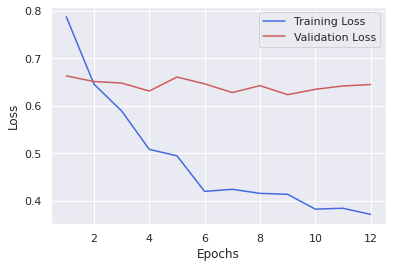

In [114]:
epochs = range(1, len(history.history['loss'])+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


# b+ is for "blue cross"
plt.plot(epochs, training_loss, color='royalblue', label='Training Loss')
# "bo" is for "blue dot"
plt.plot(epochs, validation_loss, color='indianred', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

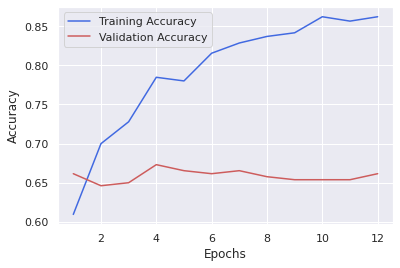

In [115]:
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']


# b+ is for "blue cross"
plt.plot(epochs, training_acc, color='royalblue', label='Training Accuracy')
# "bo" is for "blue dot"
plt.plot(epochs, validation_acc, color='indianred', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()